<a href="https://colab.research.google.com/github/online6731/Vehicle-Classification/blob/main/Vehicle_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)


# Problem

## Vehicle Classification

**Problem**: Classify the vehicles by their size

**Dataset**: Data is gathered from pictures of vehicles in highways.

**Records**: Each record contains the location of vehicle and it's class. 
<x1, y1, x2, y2, class>

**Classes**: Bus, Microbus, Minivan, Sedan, SUV, and Truck. 

**Frequency**: 558, 883 , 476 , 5,922, 1,392, and 822. 

<p align="center">
<img src='https://github.com/online6731/Vehicle-Classification/blob/main/dataset-info-1.jpg?raw=true'>
</p>

<p align="center">
<img  src='https://github.com/online6731/Vehicle-Classification/blob/main/dataset-info-2.png?raw=true'>
</p>


# Environmet

## Imports

In [119]:
import re
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from functools import partial 


# from pandas.plotting import parallel_coordinates
# from matplotlib.ticker import NullFormatter
# from mpl_toolkits.mplot3d import Axes3
# import matplotlib.ticker as ticker
# from sklearn import preprocessing

from sklearn import tree
from sklearn.preprocessing import LabelEncoder , OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import accuracy_score,recall_score,plot_confusion_matrix
from sklearn.metrics import classification_report,f1_score,precision_score

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML
%matplotlib inline
# %matplotlib notebook

rc('animation', html='jshtml')
matplotlib.rcParams['figure.figsize'] = (22, 10)


# axis = lambda w,h: plt.figure(figsize=(w, h)).add_subplot()

## Modules

### simple tools

In [120]:
param_full_name = lambda param: ''.join(map(str, param.items())).replace(', ', '=').replace("'", "").replace(")(", ", ")
param_short_name = lambda param: re.sub(r"([_'][a-z])[a-z]*", r'\1', ''.join(map(str, param.items()))).replace(', ', '=').replace("'", "").replace(")(", ", ").upper()

def dict_product(d):
    lists = list(itertools.product(*d.values()))
    dicts = [dict(zip(d.keys(), l)) for l in lists]
    return dicts

###def generate_model()

In [121]:
def generate_models(model, params, train, test):
    params = dict_product(params)
    models = [model(**param).fit(train, train.index) for param in params]

    return pd.DataFrame({
        'name': [str(model.__name__) + param_full_name(param) for param in params],
        'model': models,
        'param': params,
        'train_acc': [accuracy_score(train.index, model.predict(train)) for model in models], 
        'test_acc': [accuracy_score(test.index, model.predict(test)) for model in models]
    })

### def param_search()

In [122]:
def param_search(model, train, test, params, ax=None, max_result_count=-1):
    # run a grid search for model on parameter space and plots the results

    params = dict_product(params)
    models = [model(**param).fit(train, train.index) for param in params]

    result = {
        'name': [model.__name__ + param_full_name(param) for param in params],
        'train': [accuracy_score(train.index, model.predict(train)) for model in models], 
        'test': [accuracy_score(test.index, model.predict(test)) for model in models]}
    
    result['score_name'] = [f"{result['name'][i]}={result['test'][i]:.3f}" for i in range(len(models))]
    result.update({name:[param[name] for param in params] for name in params[0].keys()})

    result = pd.DataFrame(result).sort_values(list(params[0].keys())).sort_values('test', ascending=False).head(min(max_result_count, len(result)))
    
    ax = plt.figure(figsize=(10, len(result) // 2)).add_subplot()
    sns.barplot(x="train", y="score_name", data=result, orient='h', color='lightblue', ax=ax)
    sns.barplot(x="test", y="score_name", data=result, orient='h', color='blue', ax=ax)

    return result


### def plot_decision_surface()

In [123]:
def plot_decision_surface(model, train, test, ax=None, title=''):
    # plots the decision srface for given model

    if ax:
        ax.set_title(title)
    
    dots = np.dstack(np.meshgrid(np.arange(train['width'].min(), train['width'].max(), 2),
                                 np.arange(train['height'].min(), train['height'].max(), 2))).reshape(-1, 2)

    dots = pd.DataFrame({'width': dots[:,0], 
                         'height': dots[:,1], 
                         'Prediction': model.predict(dots)})

    sns.scatterplot(data=dots, x='width', y='height', hue='Prediction',
                    hue_order=sorted(train.index.unique()),
                    s=50, marker='s', linewidth=0, legend=False, ax=ax)


    sns.scatterplot(data=test.reset_index(), x='width', y='height', hue='name',
                    hue_order=sorted(train.index.unique()),
                    # s=20, linewidth=.1, 
                    linestyle='-', ax=ax)

# Dataset

## Load the Dataset

In [124]:
df = pd.read_csv('https://github.com/online6731/Vehicle-Classification/blob/main/vehicles.csv?raw=true',
                 names=['x1', 'y1', 'x2', 'y2', 'name'])
df.set_index('name', inplace=True) # set the label column as index
df

x1  y1   x2   y2
name                    
suv    129   0  202   73
suv     86  61  189  189
suv    129  21  210  116
sedan  145   1  212   66
sedan  108  73  201  183
...    ...  ..  ...  ...
truck  126   0  325  187
truck  101   0  297  195
truck  107   0  300  180
truck  121   0  326  186
truck   65   0  273  202

[10053 rows x 4 columns]

## Fix the Data

In [125]:
df = df[(df['x1'] <= df['x2']) &
        (df['y1'] <= df['y2']) &
        (0 <= df['x1']) &
        (0 <= df['x2']) &
        (0 <= df['y1']) &
        (0 <= df['y2'])]
df

x1  y1   x2   y2
name                    
suv    129   0  202   73
suv     86  61  189  189
suv    129  21  210  116
sedan  145   1  212   66
sedan  108  73  201  183
...    ...  ..  ...  ...
truck  126   0  325  187
truck  101   0  297  195
truck  107   0  300  180
truck  121   0  326  186
truck   65   0  273  202

[10053 rows x 4 columns]

## Find new Features

In [126]:
df['width'] = df['x2'] - df['x1']
df['height'] = df['y2'] - df['y1']
df['diameter'] = np.sqrt(df['width']**2 + df['height']**2)
df['area'] = df['width'] * df['height']
df

x1  y1   x2   y2  width  height    diameter   area
name                                                      
suv    129   0  202   73     73      73  103.237590   5329
suv     86  61  189  189    103     128  164.295466  13184
suv    129  21  210  116     81      95  124.843903   7695
sedan  145   1  212   66     67      65   93.348808   4355
sedan  108  73  201  183     93     110  144.045132  10230
...    ...  ..  ...  ...    ...     ...         ...    ...
truck  126   0  325  187    199     187  273.075081  37213
truck  101   0  297  195    196     195  276.479656  38220
truck  107   0  300  180    193     180  263.910970  34740
truck  121   0  326  186    205     186  276.804986  38130
truck   65   0  273  202    208     202  289.944822  42016

[10053 rows x 8 columns]

## Scatter Plots

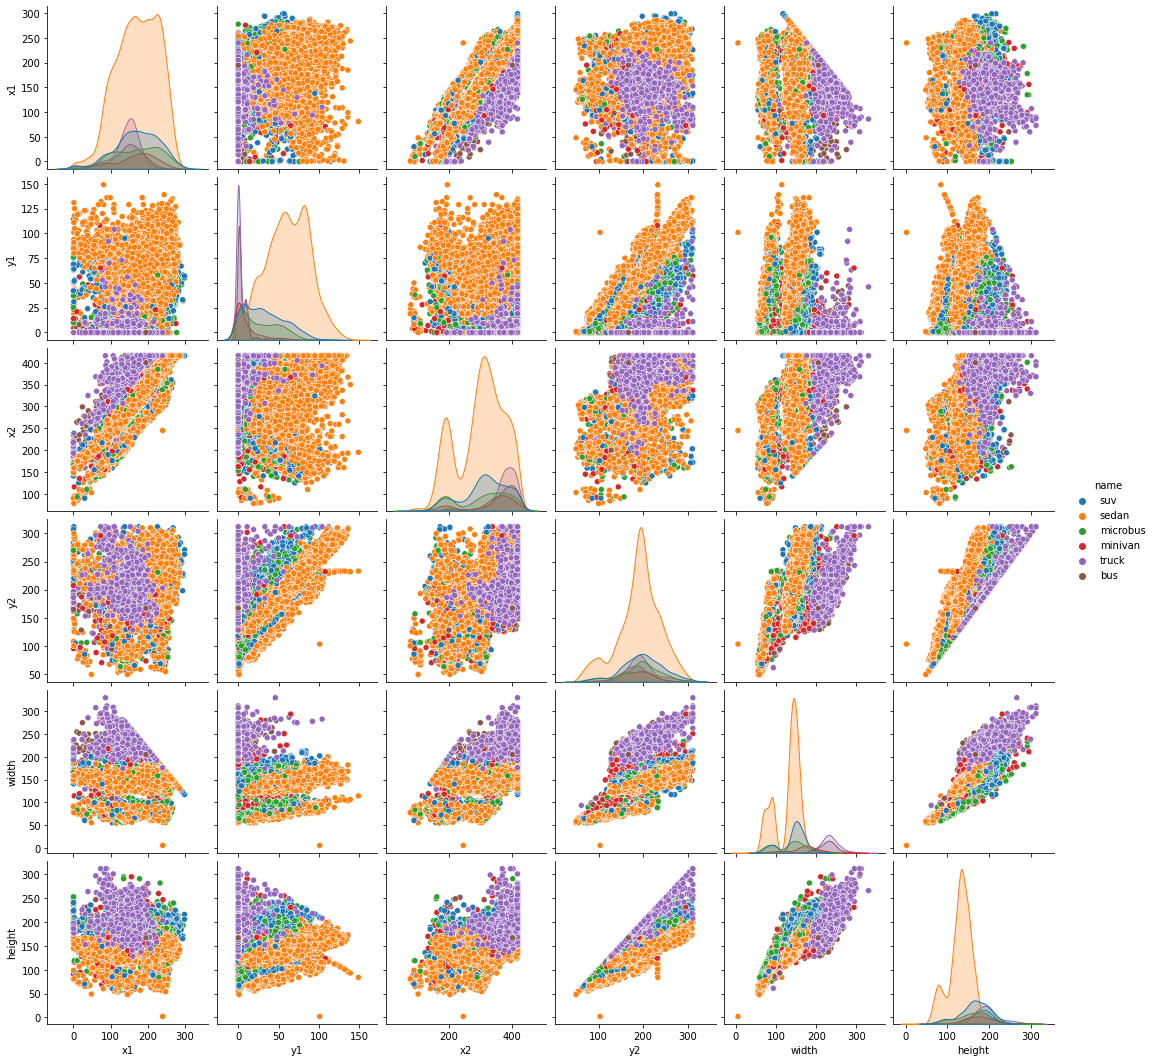

In [127]:
sns.pairplot(df.drop(columns=['diameter', 'area']).reset_index(),
             hue='name');

## Violin Plots

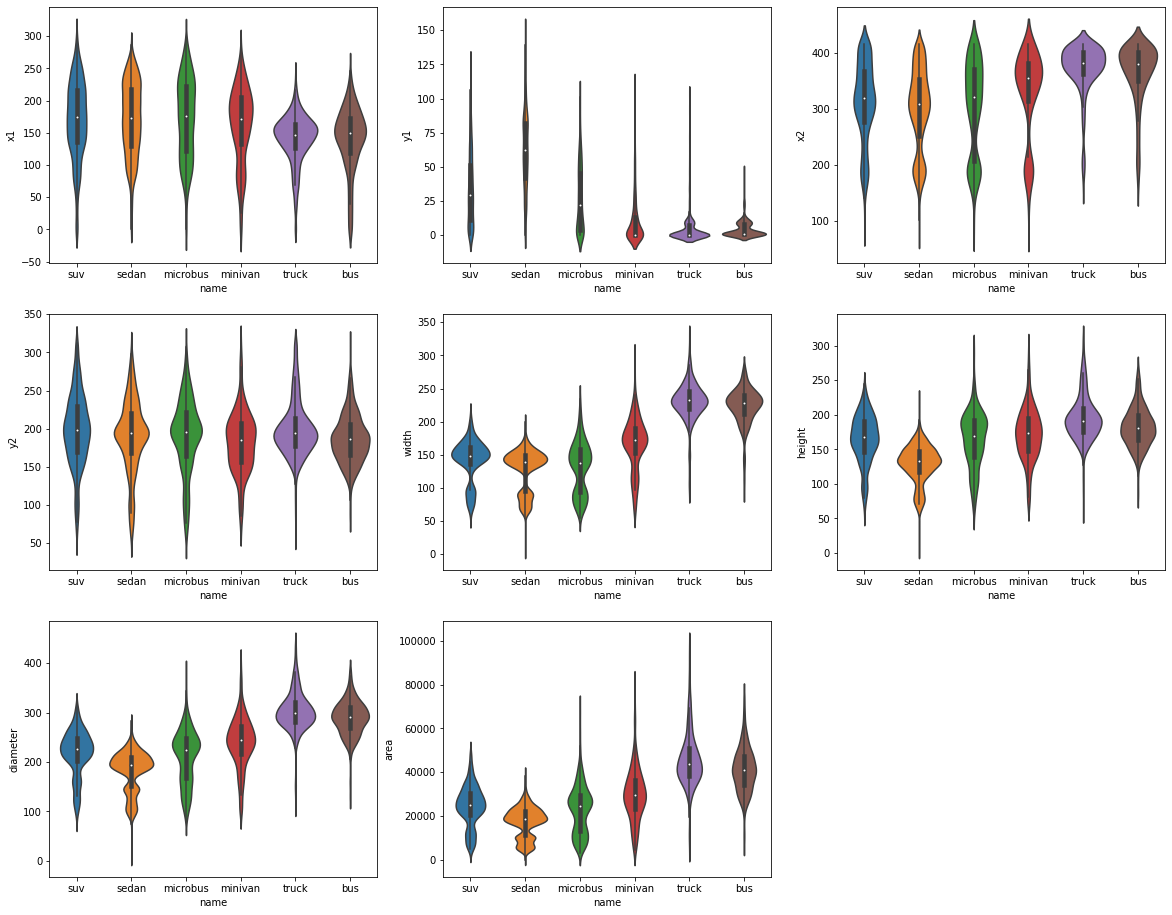

In [128]:
fig = plt.subplots(figsize=(20,16))

for i, column in enumerate(df.columns):
    sns.violinplot(x=df.index,
                   y=column,
                   data=df,
                   ax=plt.subplot(f'33{i+1}'))

# Model

## Comparison of Algorithms
Models with Default Parameters


### Scores

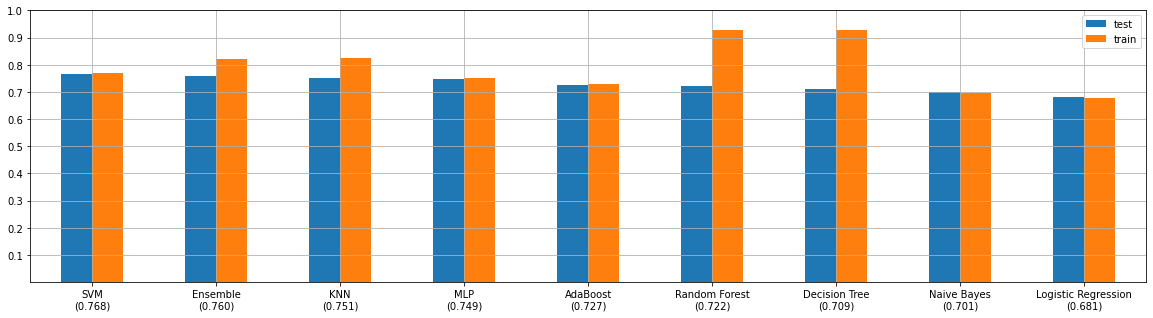

In [129]:
train, test = train_test_split(df.drop(columns=['x1', 'y1', 'x2', 'y2', 'area', 'diameter']),
                               test_size=0.2,
                               random_state=1)

models = {'Decision Tree': DecisionTreeClassifier(),
          'Logistic Regression': LogisticRegression(),
          'KNN': KNeighborsClassifier(),
          'Naive Bayes': GaussianNB(),
          'SVM': SVC(),
          'AdaBoost': AdaBoostClassifier(),
          'Random Forest': RandomForestClassifier(),
          'MLP': MLPClassifier()}
models['Ensemble'] = VotingClassifier(list(models.items()))

# training all the models
models = {name:model.fit(train, train.index) for name, model in models.items()}

result = {'name': models.keys(),
          'test': [accuracy_score(test.index, model.predict(test)) for model in models.values()],
          'train': [accuracy_score(train.index, model.predict(train)) for model in models.values()]}

# model name with accuracy score - example: SVM (0.789)
result['show_name'] = [f"{name}\n({result['test'][i]:.3f})" for i,name in enumerate(models.keys())]

result = pd.DataFrame(result,
                      index=result['show_name']
                      ).sort_values('test', ascending=False)

result.plot.bar(rot=0,
                grid=True,
                figsize=(20,5),
                yticks=np.arange(1,0,-.1));

#### Explanation
...

### Confusion Matrix

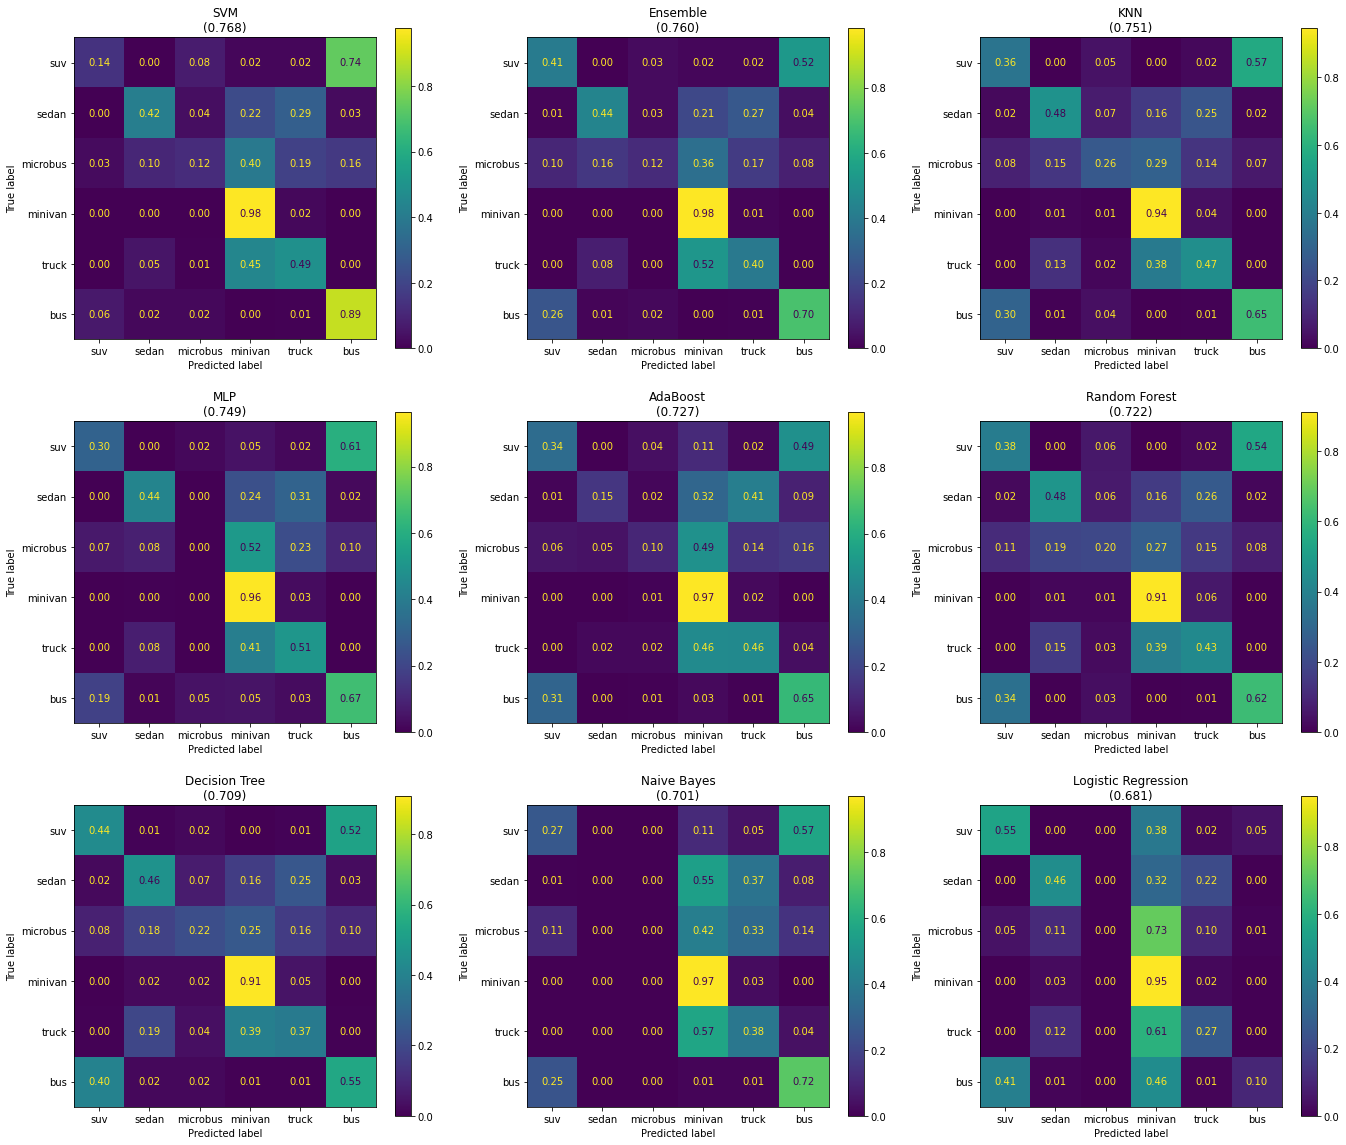

In [130]:
fig = plt.subplots(figsize=(23,20))
ax = [plt.subplot(f'33{i+1}') for i in range(9)]

# set plot titles
[ax[i].set_title(name) for i, name in enumerate(result['show_name'])]

for i, name in enumerate(result['name']):
    plot_confusion_matrix(models[name],
                          test,
                          test.index,
                          normalize='true',
                          values_format='.2f',
                          display_labels=df.index.unique(),
                          ax=ax[i])

#### Explanation
...


### Decision Surface

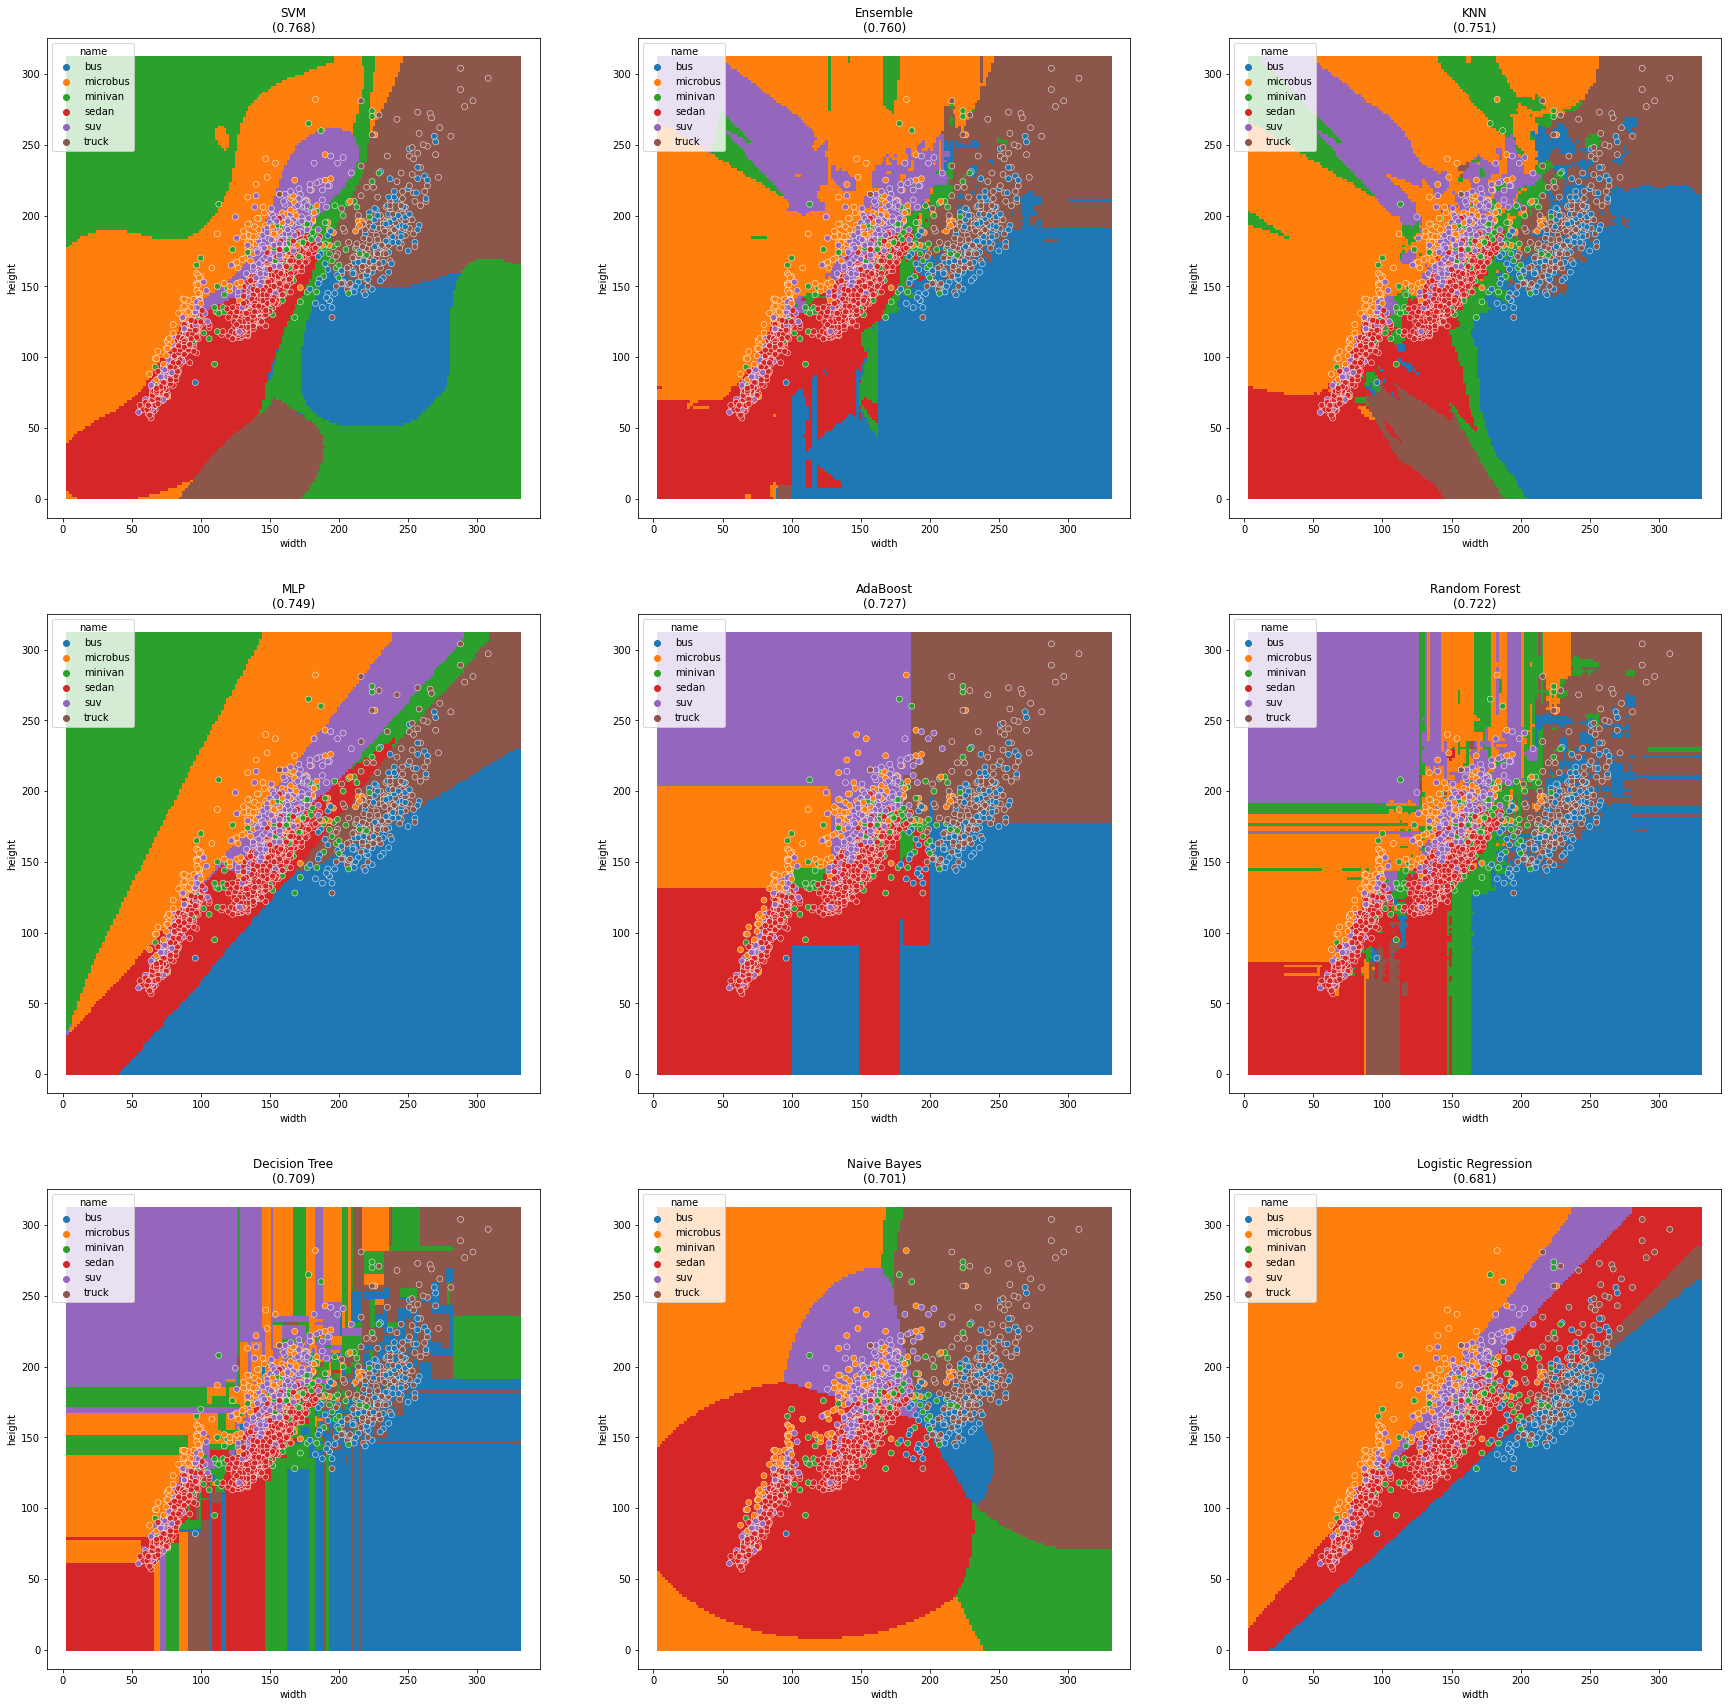

In [131]:
fig = plt.subplots(figsize=(30,30))
ax = [plt.subplot(f'33{i+1}') for i in range(9)]

for i,name in enumerate(result['name']):
    plot_decision_surface(models[name],
                          train,
                          test,
                          ax=ax[i],
                          title=result['show_name'][i])

#### Explanation
...


## Model Examination

#### Tree

[Text(558.0, 380.52, 'width <= 179.5\ngini = 0.6\nsamples = 100.0%\nvalue = [0.1, 0.1, 0.0, 0.6, 0.1, 0.1]\nclass = bus'),
 Text(279.0, 271.8, 'height <= 170.5\ngini = 0.5\nsamples = 83.0%\nvalue = [0.0, 0.1, 0.0, 0.7, 0.2, 0.0]\nclass = bus'),
 Text(139.5, 163.07999999999998, 'height <= 152.5\ngini = 0.3\nsamples = 70.6%\nvalue = [0.0, 0.1, 0.0, 0.8, 0.1, 0.0]\nclass = bus'),
 Text(69.75, 54.360000000000014, '\n  (...)  \n'),
 Text(209.25, 54.360000000000014, '\n  (...)  \n'),
 Text(418.5, 163.07999999999998, 'width <= 145.5\ngini = 0.7\nsamples = 12.5%\nvalue = [0.0, 0.3, 0.1, 0.1, 0.5, 0.0]\nclass = microbus'),
 Text(348.75, 54.360000000000014, '\n  (...)  \n'),
 Text(488.25, 54.360000000000014, '\n  (...)  \n'),
 Text(837.0, 271.8, 'width <= 203.5\ngini = 0.7\nsamples = 17.0%\nvalue = [0.3, 0.0, 0.1, 0.0, 0.0, 0.5]\nclass = minivan'),
 Text(697.5, 163.07999999999998, 'height <= 204.5\ngini = 0.8\nsamples = 3.8%\nvalue = [0.2, 0.1, 0.3, 0.1, 0.2, 0.1]\nclass = suv'),
 Text(627.75, 5

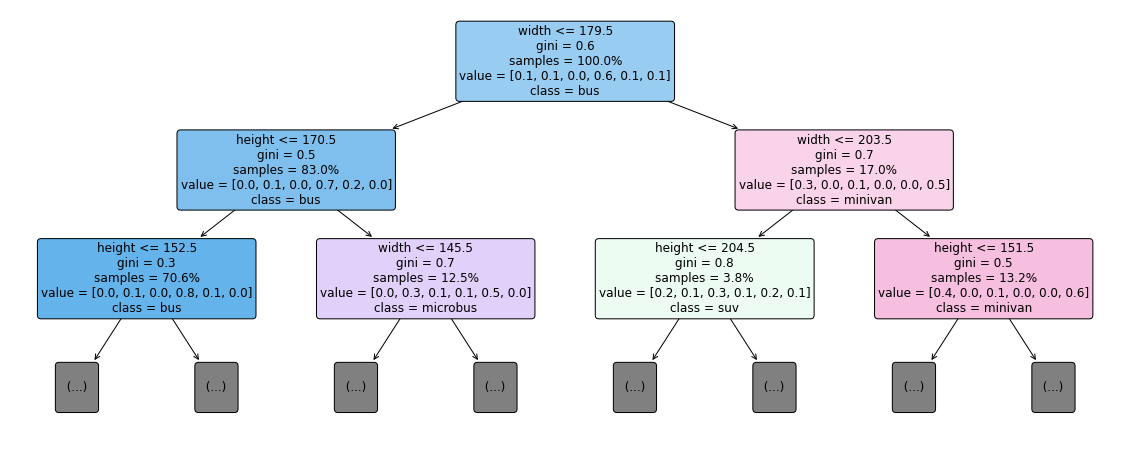

In [132]:
tree.plot_tree(models['Decision Tree'],
               feature_names=train.columns,
               class_names=train.index.unique(),
               filled=True,
               rounded=True,
               proportion=True,
               max_depth=2,
               precision=1,
               fontsize=12,
               ax=plt.figure(figsize=(20, 8)).add_subplot())

#### Decision Surface

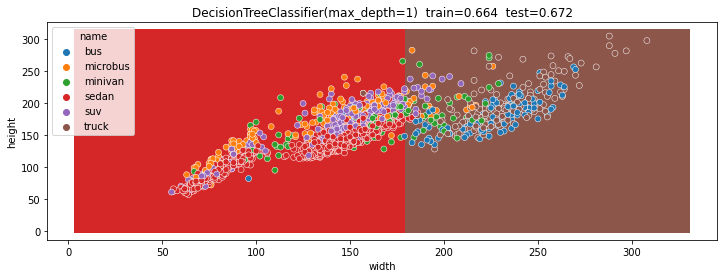

In [133]:
fig, ax = plt.subplots(figsize=(12,4))

_models = generate_models(model=DecisionTreeClassifier,
                          params={'max_depth': list(range(1, 20))},
                          train=train,
                          test=test)

def animate(i):
    plt.cla()
    title = f"{_models['name'][i]}  train={_models['train_acc'][i]:.3f}  test={_models['test_acc'][i]:.3f}"
    plot_decision_surface(model=_models['model'][i],
                          train=train,
                          test=test,
                          ax=ax,
                          title=title)

FuncAnimation(fig,
              animate,
              interval=1000,
              frames=len(_models))

#### Parameter Tuning

##### Decision Tree

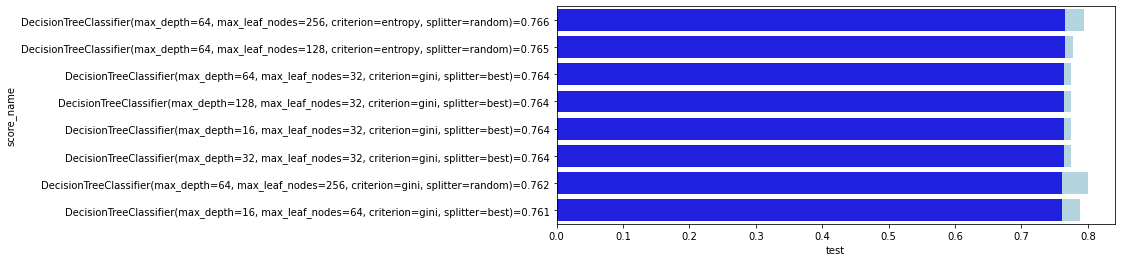

In [134]:
param_search(train=train,
             test=test,
             model=DecisionTreeClassifier,
             max_result_count=10,
             params={'max_depth': [2**i for i in range(1, 8)],
                     'max_leaf_nodes': [2**i for i in range(5, 10)],
                     'criterion': ['gini', 'entropy'],
                     'splitter': ['best', 'random']});

##### Logistic Regression

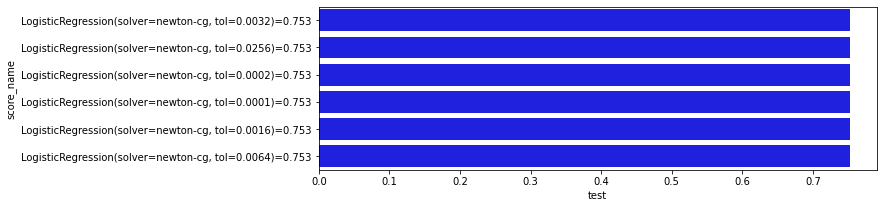

In [135]:
param_search(train=train,
             test=test,
             model=LogisticRegression,
             max_result_count=10,
             params={'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                     'tol': [2**i/10**4 for i in range(10)]});

#### Tree

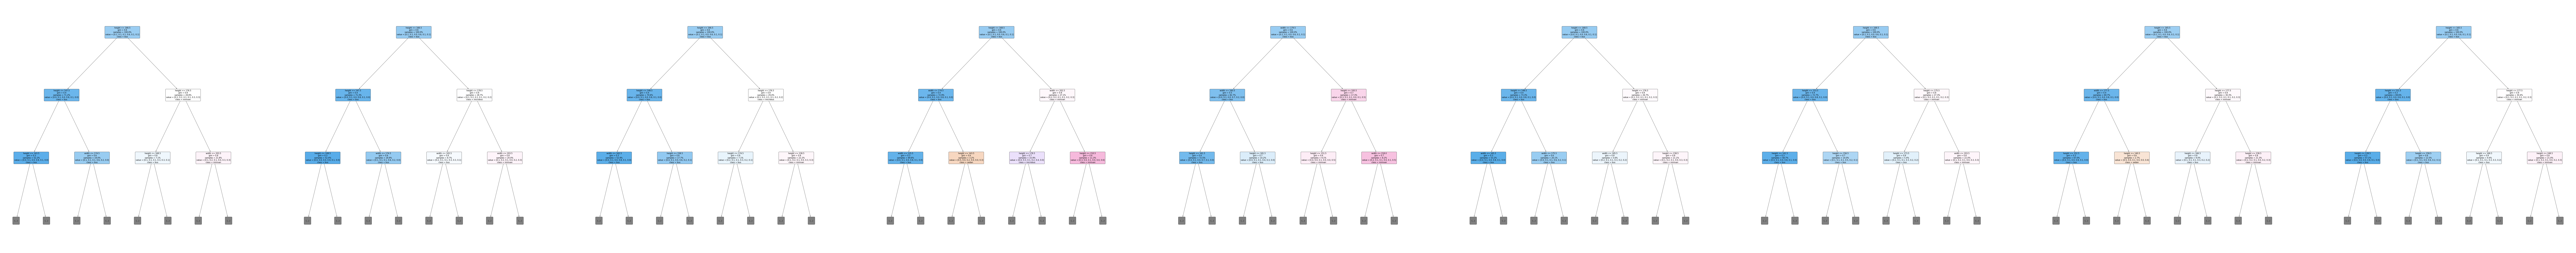

In [136]:
estimators_n = min(len(models['Random Forest'].estimators_), 9)
fig = plt.subplots(figsize=(estimators_n*40, estimators_n*4))
ax = [plt.subplot(f'1{estimators_n}{i+1}') for i in range(estimators_n)]

for i in range(estimators_n):
    tree.plot_tree(models['Random Forest'].estimators_[i],
                   feature_names=train.columns,
                   class_names=train.index.unique(),
                   filled=True, rounded=True, proportion=True, max_depth=2,
                   precision=1, fontsize=15, ax=ax[i]);

# output can be seen in fullscreen mode